In [16]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [17]:
mean_gray = 0.1307
stddev_gray = 0.3081

# the below step transforms the input data as given in the list
# 1. this is part of preprocessing step
transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean_gray,stddev_gray)])

train_dataset = datasets.MNIST(root = './data',
                               train=True,
                               transform=transforms,
                               download=True)

test_dataset = datasets.MNIST(root = './data',
                               train=False,
                               transform=transforms,
                               download=True)

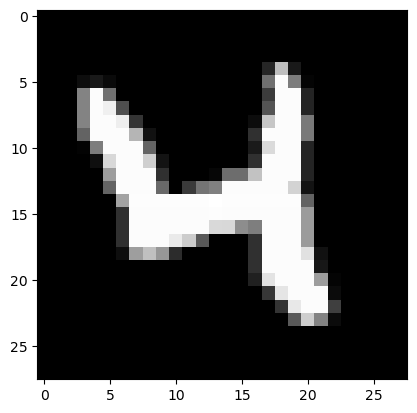

In [18]:
import matplotlib.pyplot as plt
random_img = train_dataset[20][0].numpy()*stddev_gray + mean_gray
plt.imshow(random_img.reshape(28,28),cmap = 'gray')

In [19]:
train_dataset[20][1]

4

In [20]:

batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle = False)

In [21]:
print(len(train_dataset))
print(len(train_loader))
print(len(test_dataset))
print(len(test_loader))

60000
600
10000
100


In [23]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        # same padding ---> input size = output size
        # padding = (kernel_size -1)/2 --> (3-1)/2 = 1
        self.cnn1 = nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        # the image size after the maxpool is 14x14 means 28/2
        self.cnn2 = nn.Conv2d(in_channels=8,out_channels=32,kernel_size=5,stride=1,padding=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(0.2)
        # for linear layers the output size is 7x7x32 = 1568
        self.fc1 = nn.Linear(1568,600)
        self.fc2 = nn.Linear(600,10)

    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        # now we need to flatten the layer So that we can pass it to the FC layers
        out = out.view(-1,1568)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [26]:
model = CNN()

CUDA = torch.cuda.is_available()

if CUDA:
    model = model.cuda()
    print("Cuda is Available!")

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)

Cuda is Available!


In [32]:
# Training the CNN
num_epochs = 10

train_accuracy = []
train_loss = []
test_accuracy = []
test_loss = []


for epoch in range(num_epochs):

    # Train Phase
    correct = 0
    iterations = 0
    iter_loss = 0.0

    model.train()
    
    for i,(inputs,labels) in enumerate(train_loader):

        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = loss_fn(outputs,labels)
        iter_loss += loss.item()

        # update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        _,predicted = torch.max(outputs,1)
        correct += (predicted==labels).sum().item()
        iterations += 1

    train_loss.append(iter_loss/iterations)
    train_accuracy.append((correct/len(train_loader)))

    # Test phase
    test_loss_val = 0.0
    correct = 0
    iterations = 0

    model.eval()

    for i,(inputs,labels) in enumerate(test_loader):

        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = model(inputs)
        loss = loss_fn(outputs,labels)
        test_loss_val += loss.item()

        _,predicted = torch.max(outputs,1)
        correct += (predicted==labels).sum().item()
        iterations += 1

    test_loss.append(test_loss_val/iterations)
    test_accuracy.append((correct/len(test_loader)))

    print('Epochs : {}/{} , Train_Loss : {:.3f} , Test_Loss : {:.3f}, Train_Accuracy : {:.3f}, Test_Accuracy : {:.3f}'.format(epoch+1,num_epochs,
                                                                                                                             train_loss[-1],test_loss[-1],
                                                                                                                              train_accuracy[-1],test_accuracy[-1]))

Epochs : 1/10 , Train_Loss : 0.020 , Test_Loss : 0.050, Train_Accuracy : 99.432, Test_Accuracy : 98.900
Epochs : 2/10 , Train_Loss : 0.023 , Test_Loss : 0.047, Train_Accuracy : 99.328, Test_Accuracy : 99.100
Epochs : 3/10 , Train_Loss : 0.020 , Test_Loss : 0.057, Train_Accuracy : 99.425, Test_Accuracy : 98.830
Epochs : 4/10 , Train_Loss : 0.022 , Test_Loss : 0.048, Train_Accuracy : 99.363, Test_Accuracy : 99.180
Epochs : 5/10 , Train_Loss : 0.022 , Test_Loss : 0.052, Train_Accuracy : 99.425, Test_Accuracy : 99.140
Epochs : 6/10 , Train_Loss : 0.021 , Test_Loss : 0.089, Train_Accuracy : 99.425, Test_Accuracy : 99.020
Epochs : 7/10 , Train_Loss : 0.025 , Test_Loss : 0.054, Train_Accuracy : 99.352, Test_Accuracy : 99.000
Epochs : 8/10 , Train_Loss : 0.020 , Test_Loss : 0.058, Train_Accuracy : 99.435, Test_Accuracy : 99.110
Epochs : 9/10 , Train_Loss : 0.024 , Test_Loss : 0.050, Train_Accuracy : 99.378, Test_Accuracy : 99.060
Epochs : 10/10 , Train_Loss : 0.017 , Test_Loss : 0.062, Train_A

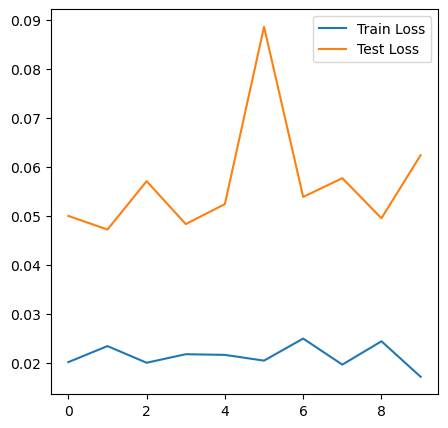

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5,5))
plt.plot(train_loss,label = 'Train Loss')
plt.plot(test_loss,label = 'Test Loss')
plt.legend()
plt.show()

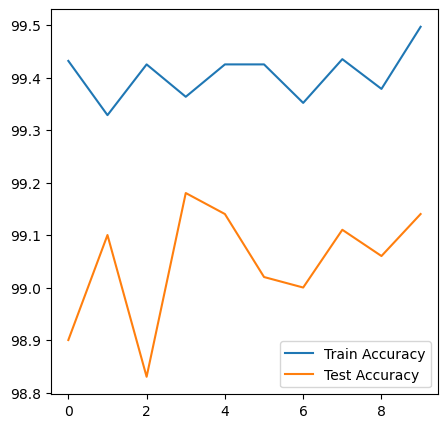

In [36]:
fig = plt.figure(figsize=(5,5))
plt.plot(train_accuracy,label = 'Train Accuracy')
plt.plot(test_accuracy,label = 'Test Accuracy')
plt.legend()
plt.show()